In [1]:
import pandas
import matplotlib
import seaborn
import collections
import itertools
import igraph

import sys
sys.path.append('..')

from helpers import (ECOSYSTEMS, DATE_RANGE, load_graph, evolution_regression, evolution_linlog_regressions, 
                     savefig, x_index, gini)

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('Set1', n_colors=len(ECOSYSTEMS))
seaborn.set_style('whitegrid')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Use a subset of dates to speed up the notebook. 
# THIS LINE SHOULD BE COMMENTED IN PRODUCTION!
# DATE_RANGE = pandas.date_range(DATE_RANGE[0], DATE_RANGE[-1], freq='3MS')

FIG_SIZE = (8, 4)
FIG_SIZE_WIDE = (10, 4)
COLORS = {ecosystem: seaborn.color_palette()[i] for i, ecosystem in enumerate(ECOSYSTEMS)}
sub = lambda c, e: [c[x] for x in e]

In [3]:
graphs = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=': ')
    graphs[ecosystem] = collections.OrderedDict()
    
    for date in DATE_RANGE: 
        print('.', end='')
        graphs[ecosystem][date] = load_graph(ecosystem, date)
    
    print()

cargo: .............................................................
cpan: .............................................................
cran: .............................................................
npm: .............................................................
nuget: .............................................................
packagist: .............................................................
rubygems: .............................................................


## Graph size

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


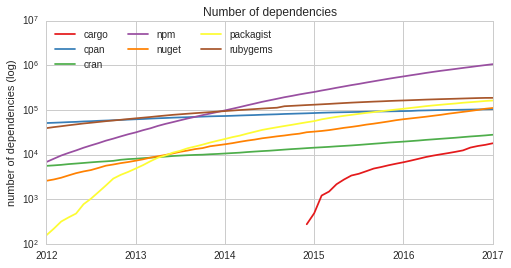

In [4]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue        
        df.loc[date, ecosystem] =  graph.ecount()
    
df.plot(ax=ax, logy=True, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='number of dependencies (log)',
    title='Number of dependencies',
)
ax.legend(loc='upper left', ncol=len(ECOSYSTEMS) // 2)
savefig(figure, 'graph_number_of_dependencies')

In [5]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.968174,0.997731,0.949218,0.851819,0.885422,0.926782,0.996761
lin-log,0.852518,0.98289,0.997858,0.982219,0.988464,0.87518,0.968479
log-lin,0.515419,0.643649,0.49523,0.363323,0.40371,0.430846,0.606653
log-log,0.878857,0.699342,0.640579,0.716718,0.702121,0.827576,0.728969


## Distribution of dependencies

In [6]:
data = []
date = DATE_RANGE[-1]

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    for node in graph.vs:
        if node['in'] + node['out'] == 0:
            continue

        if node['in'] > 0:
            if node['out'] > 0:
                p_type = 'both'
            else:
                p_type = 'required'
        else:
            p_type = 'dependent'
            
        data.append((
            ecosystem, 
            p_type, 
            node['in'],
            node['out'],
            node['tr-in'],
            node['tr-out']
        ))
        
data = (
    pandas.DataFrame.from_records(
        data, 
        columns=['ecosystem', 'p_type', 'in', 'out', 'tr-in', 'tr-out']
    )
    .pipe(
        pandas.melt,
        id_vars=['ecosystem', 'p_type'], 
        value_vars=['in', 'out', 'tr-in', 'tr-out'], 
        var_name='kind'
    )
)

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


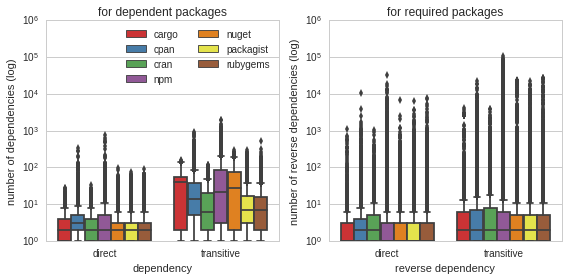

In [7]:
figure, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True)
figure.set_size_inches(FIG_SIZE)

bx_ = seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=data.query('(kind == "out" or kind == "tr-out") and p_type != "required"'),
    ax=axes[0],
    order=['out', 'tr-out'],
    hue_order=ECOSYSTEMS,
    palette=COLORS
)

axes[0].set(
    xlabel='dependency', 
    ylabel='number of dependencies (log)',
    yscale='log',
    title='for dependent packages',
)
axes[0].set_xticklabels(['direct', 'transitive'])
axes[0].legend(ncol=2)


seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=data.query('(kind == "in" or kind == "tr-in") and p_type != "dependent"'),
    ax=axes[1],
    order=['in', 'tr-in'],
    hue_order=ECOSYSTEMS,
    palette=COLORS
)

axes[1].set(
    xlabel='reverse dependency', 
    ylabel='number of reverse dependencies (log)',
    yscale='log',
    title='for required packages',
)

axes[1].set_xticklabels(['direct', 'transitive'])
axes[1].legend([])

matplotlib.pyplot.setp(axes[1].get_yticklabels(), visible=True)
matplotlib.pyplot.tight_layout()

savefig(figure, 'graph_distribution_dependencies_non_isolated')

In [8]:
(
    data
    .query('(kind == "out" or kind == "tr-out") and p_type != "required"')
    .groupby(['ecosystem', 'kind'])
    ['value']
    .describe()
    .unstack()
)

count                mean                  std              min  \
kind            out    tr-out       out     tr-out       out      tr-out  out   
ecosystem                                                                       
cargo        5272.0    5272.0  3.372724  34.476480  3.117645   34.472030  1.0   
cpan        24229.0   24229.0  4.287548  28.145033  6.369321   40.233886  1.0   
cran         7890.0    7890.0  3.386312  14.162231  2.885716   17.429169  1.0   
npm        252422.0  252422.0  4.165140  67.637472  6.437355  112.128728  1.0   
nuget       41297.0   41297.0  2.670581  39.435383  3.325654   45.511829  1.0   
packagist   60064.0   60064.0  2.688499  14.073155  3.215438   19.355898  1.0   
rubygems    77859.0   77859.0  2.387174  13.130210  2.491919   17.005556  1.0   

                  25%         50%         75%           max          
kind      tr-out  out tr-out  out tr-out  out tr-out    out  tr-out  
ecosystem                                                            
cargo        1.0  1.0    2.0  2.0   41.0  4.0   56.0   28.0   155.0  
cpan         1.0  2.0    5.0  3.0   14.0  5.0   37.0  343.0   924.0  
cran         1.0  1.0    2.0  2.0    6.0  4.0   20.0   33.0   117.0  
npm          1.0  1.0    3.0  2.0   21.0  5.0   82.0  765.0  1998.0  
nuget        1.0  1.0    2.0  2.0   27.0  3.0   76.0   98.0   296.0  
packagist    1.0  1.0    3.0  2.0    7.0  3.0   17.0   75.0   305.0  
rubygems     1.0  1.0    2.0  2.0    7.0  3.0   16.0   91.0   519.0

In [9]:
(
    data
    .query('(kind == "in" or kind == "tr-in") and p_type != "dependent"')
    .groupby(['ecosystem', 'kind'])
    ['value']
    .describe()
    .unstack()
)

count                mean                     std               \
kind            in    tr-in         in       tr-in          in        tr-in   
ecosystem                                                                     
cargo       2205.0   2205.0   8.063946   82.430839   46.947184   400.030467   
cpan        9744.0   9744.0  10.661227   69.984195  129.700930   597.576961   
cran        2517.0   2517.0  10.615018   44.394120   46.044459   226.651330   
npm        86677.0  86677.0  12.129781  196.974815  206.919076  2377.141813   
nuget      16127.0  16127.0   6.838656  100.983630   68.774332  1097.013266   
packagist  20735.0  20735.0   7.787895   40.766337   80.337347   473.954448   
rubygems   16761.0  16761.0  11.089016   60.993079  125.041931   762.056299   

           min        25%        50%        75%            max            
kind        in tr-in   in tr-in   in tr-in   in tr-in       in     tr-in  
ecosystem                                                                 
cargo      1.0   1.0  1.0   1.0  1.0   2.0  3.0   6.0   1114.0    4102.0  
cpan       1.0   1.0  1.0   1.0  2.0   2.0  4.0   7.0  10797.0   21843.0  
cran       1.0   1.0  1.0   1.0  2.0   2.0  5.0   8.0   1048.0    3816.0  
npm        1.0   1.0  1.0   1.0  1.0   2.0  3.0   6.0  32039.0  105634.0  
nuget      1.0   1.0  1.0   1.0  1.0   2.0  3.0   5.0   7022.0   23173.0  
packagist  1.0   1.0  1.0   1.0  1.0   2.0  3.0   5.0   6380.0   22526.0  
rubygems   1.0   1.0  1.0   1.0  1.0   2.0  3.0   5.0   7671.0   27866.0

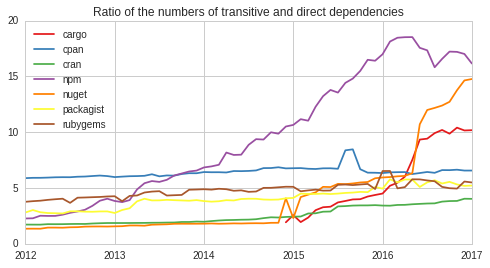

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = sum(node['tr-out'] for node in graph.vs.select(**{'tr-out_gt': 0})) / graph.ecount()
        
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Ratio of the numbers of transitive and direct dependencies',
)

savefig(figure, 'graph_ratio_transitive_per_direct')

In [11]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,1.927007,10.407472,10.1804
cpan,5.883760,8.464031,6.56367
cran,1.716281,4.038870,4.02812
npm,2.269474,18.522114,16.1572
nuget,1.351852,14.764984,14.765
packagist,2.716883,5.778226,5.2198
rubygems,3.668201,6.525641,5.49659


/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


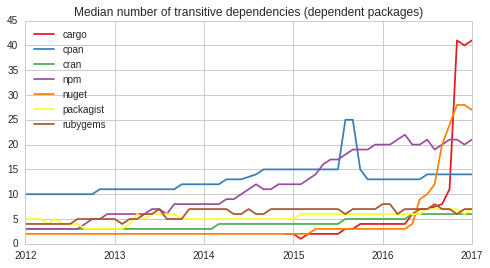

In [12]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = pandas.np.median(
            [v['tr-out'] for v in graph.vs if v['out'] > 0]
        )
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Median number of transitive dependencies (dependent packages)',
)

savefig(figure, 'graph_median_transitive_dependencies')

In [13]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,1.0,41.0,41
cpan,10.0,25.0,14
cran,3.0,6.0,6
npm,3.0,22.0,21
nuget,2.0,28.0,27
packagist,3.0,7.0,7
rubygems,4.0,8.0,7


## Gini index

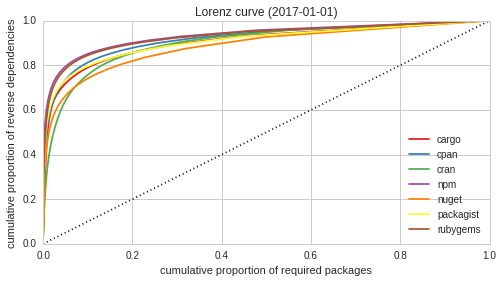

In [14]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

date = DATE_RANGE[-1]

data_temp = []

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    df = (
        pandas.DataFrame(graph.vs['in'], columns=['in'])
        .pipe(lambda d: d[d['in'] > 0])
        .sort_values('in', ascending=False)
        .assign(n=lambda d: 1 / len(d))
        .assign(p=lambda d: d['in'] / d['in'].sum())
        [['n', 'p']]
        .cumsum()
        .set_index('n')
        .rename(columns={'p': ecosystem})
    )
    data_temp.append(df)
    df.plot(ax=ax)


ax.plot([0, 1], [0, 1], 'k:')
    
ax.set(
    title='Lorenz curve ({})'.format(DATE_RANGE[-1].strftime('%Y-%m-%d')),
    xlim=(0, 1),
    ylim=(0, 1),
    xlabel='cumulative proportion of required packages',
    ylabel='cumulative proportion of reverse dependencies',
)

savefig(figure, 'graph_required_lorenz')

In [15]:
for df in data_temp:
    ecosystem = df.columns[0]
    perc = (
        df
        .query('{} >= 0.8'.format(ecosystem))
        .reset_index()
        ['n']
        .iloc[0]
    )
    print('{}: {}'.format(ecosystem, perc))

cargo: 0.11065759637188247
cpan: 0.08856732348111825
cran: 0.1319030591974568
npm: 0.053197503374593356
nuget: 0.16822719662676736
packagist: 0.10421991801302066
rubygems: 0.05960264900662213


In [16]:
data_temp = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        data_temp.loc[date, ecosystem] = len(graph.vs.select(in_gt=0))

data_temp

,cargo,cpan,cran,npm,nuget,packagist,rubygems
2012-01-01,0,5775,925,1299,726,37,4789
2012-02-01,0,5822,939,1469,793,51,4993
2012-03-01,0,5889,958,1644,844,64,5164
2012-04-01,0,5951,982,1838,936,72,5355
2012-05-01,0,6006,995,2037,1030,80,5558
2012-06-01,0,6067,1021,2276,1116,113,5750
2012-07-01,0,6120,1039,2512,1175,160,5910
2012-08-01,0,6239,1060,2752,1311,207,6122
2012-09-01,0,6322,1076,3097,1418,278,6316
2012-10-01,0,6386,1092,3403,1511,368,6477


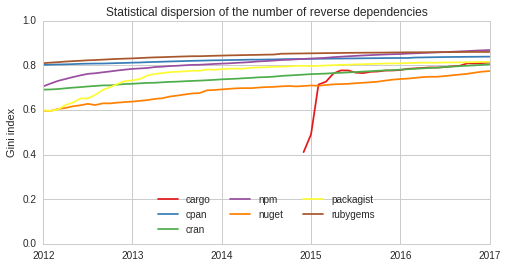

In [17]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = pandas.DataFrame(index=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        nodes_in = pandas.np.asarray(graph.vs.select(in_gt=0)['in'])
        #data_temp.loc[ecosystem, date] = gini(nodes_in)
        normalised = gini(nodes_in) / (1 - (1/len(nodes_in)))
        data_temp.loc[ecosystem, date] = normalised
    
data_temp = (
    data_temp
    .T
    .sort_index()
)

data_temp.plot(ax=ax)

ax.set(
    title='Statistical dispersion of the number of reverse dependencies',
    xlabel='',
    ylabel='Gini index',
    ylim=(0, 1),
)

ax.legend(loc='lower center', ncol=len(ECOSYSTEMS) // 2)
savefig(figure, 'graph_required_gini_index')

In [18]:
pandas.concat([data_temp.min(), data_temp.max(), data_temp.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.410780,0.812388,0.812388
cpan,0.801676,0.838616,0.838616
cran,0.690716,0.804183,0.804183
npm,0.705466,0.868028,0.868028
nuget,0.595607,0.773817,0.773817
packagist,0.595413,0.815029,0.815029
rubygems,0.809266,0.859699,0.859437


In [19]:
evolution_linlog_regressions(data_temp.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.405713,0.965964,0.99877,0.935836,0.974752,0.708354,0.908896
lin-log,0.357354,0.963986,0.997996,0.92072,0.966168,0.679293,0.904912
log-lin,0.854592,0.715315,0.645811,0.82278,0.696906,0.824136,0.792626
log-log,0.84635,0.718369,0.659056,0.840709,0.716848,0.828976,0.796818


## Type of packages

In [20]:
df_connected = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_required = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_dependent = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
            
        connected = graph.vs.select(_degree_gt=0)
        required = graph.vs.select(_indegree_gt=0)
        dependent = graph.vs.select(_outdegree_gt=0)
        
        df_connected.loc[date, ecosystem] = len(connected) / graph.vcount()
        df_required.loc[date, ecosystem] = len(required) / graph.vcount() 
        df_dependent.loc[date, ecosystem] = len(dependent) / graph.vcount()

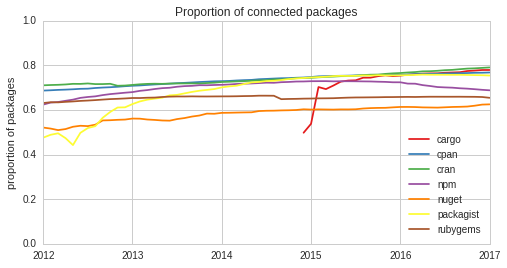

In [21]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_connected.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='',
    ylabel='proportion of packages',
    title='Proportion of connected packages',
    ylim=(0, 1),
)
savefig(figure, 'graph_prop_connected_packages')

In [22]:
pandas.concat([df_connected.min(), df_connected.max(), df_connected.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.497585,0.778736,0.778736
cpan,0.686449,0.767529,0.767529
cran,0.708062,0.790173,0.790173
npm,0.623574,0.728768,0.687715
nuget,0.509383,0.624806,0.624806
packagist,0.442249,0.758043,0.753964
rubygems,0.630682,0.663623,0.654073


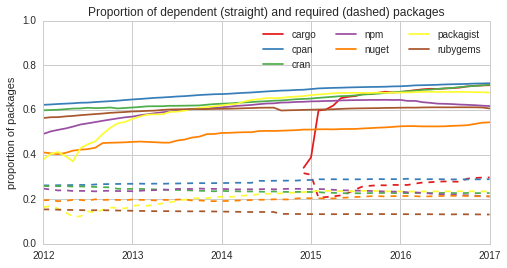

In [23]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_dependent.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
df_required.plot(ax=ax, style='--', legend=False, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='',
    ylabel='proportion of packages',
    title='Proportion of dependent (straight) and required (dashed) packages',
    ylim=(0, 1),
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(ECOSYSTEMS)], labels[:len(ECOSYSTEMS)], ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_prop_required_dependent_packages')

In [24]:
pandas.concat([df_required.min(), df_required.max(), df_required.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.206154,0.316425,0.297265
cpan,0.261604,0.291340,0.289431
cran,0.226079,0.259104,0.227351
npm,0.212109,0.247508,0.212109
nuget,0.190821,0.214966,0.212661
packagist,0.121581,0.237397,0.234486
rubygems,0.131153,0.154178,0.131153


In [25]:
pandas.concat([df_dependent.min(), df_dependent.max(), df_dependent.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.340580,0.710416,0.710416
cpan,0.622569,0.719538,0.719538
cran,0.598039,0.712673,0.712673
npm,0.492015,0.645115,0.617169
nuget,0.401311,0.544316,0.544316
packagist,0.369301,0.681301,0.677855
rubygems,0.563313,0.611619,0.606441


## Top-level packages
Top-level packages are packages that are not required but have at least one dependency.

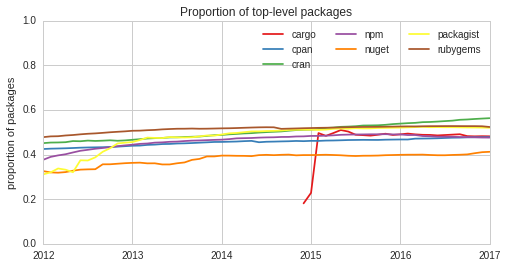

In [26]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = len(graph.vs.select(in_eq=0, out_gt=0)) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion of packages', 
    title='Proportion of top-level packages',
    ylim=(0, 1)
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_proportion_top_level')

In [27]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,0.181159,0.509674,0.481606
cpan,0.424627,0.478158,0.478158
cran,0.450980,0.562822,0.562822
npm,0.376426,0.491136,0.475756
nuget,0.318562,0.412171,0.412171
packagist,0.311111,0.523901,0.519749
rubygems,0.477878,0.527434,0.523403


In [28]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.172964,0.949648,0.992841,0.709539,0.759347,0.688395,0.779998
lin-log,0.18497,0.944099,0.995422,0.693147,0.746085,0.638876,0.771391
log-lin,0.651192,0.714981,0.575552,0.847989,0.725002,0.825192,0.831151
log-log,0.687387,0.722849,0.592462,0.863804,0.732541,0.829608,0.83551


In [29]:
evolution_linlog_regressions(df[df['cargo'] > 0.3][['cargo']].astype(float))

,cargo
lin-lin,0.349383
lin-log,0.351377
log-lin,0.185520
log-log,0.186483


In [30]:
date = DATE_RANGE[-1]

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    vs = graph.vs.select(in_eq=0, out_gt=0)
    data.extend(zip(
        itertools.repeat(ecosystem), 
        vs['out'],
        vs['tr-out']
    ))
            
df = (
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'out', 'tr-out'])
    .assign(ratio=lambda d: d['tr-out'] / d['out'])
    .pipe(lambda d: pandas.melt(d, id_vars='ecosystem', value_vars=['out', 'tr-out', 'ratio'], var_name='kind'))
)

In [31]:
date = DATE_RANGE[-1]

bins = [1, 2, 3, 4, 5, 6, pandas.np.inf]
labels = ['1', '2', '3', '4', '5', '6 or more']

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    for node in graph.vs.select(in_eq=0, out_gt=0): 
        depths = []
        for v, d, p in graph.bfsiter(node, advanced=True):
            depths.append(d)
        
        d_max = max(depths)
        d_mean = pandas.np.mean(depths)
        d_median = pandas.np.median(depths)
        
        d_count = collections.Counter(
            pandas.cut(depths, bins=bins, labels=labels, right=False, include_lowest=True)
        )
        
        data.append([ecosystem, d_max, d_mean, d_median] + [d_count[v] for v in labels])

In [32]:
df = pandas.melt(
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'depth', 'mean', 'median'] + labels),
    id_vars='ecosystem',
    value_vars=['depth', 'mean', 'median'] + labels
)

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


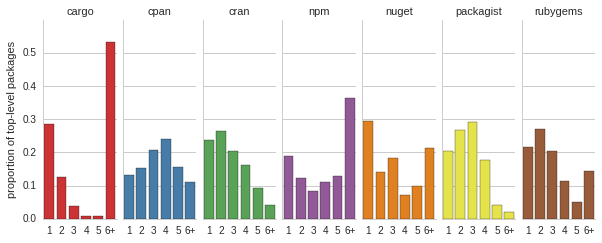

In [33]:
# Proportion of packages with at least one dependency at given depth

df_tmp = (
    df
    .query('variable == "depth"')  # Select maximal depth
    .assign(grouped_value=
        lambda d: pandas.cut(d['value'], bins=bins, labels=labels, right=False, include_lowest=True)
    )
    .groupby(['ecosystem', 'grouped_value'])
    .count()
    .pipe(lambda d: 
        d.groupby(level=0).apply(lambda x: x / x.sum())
    )
)

grid = (
    seaborn.FacetGrid(
        data=df_tmp.reset_index(),
        col='ecosystem',
        hue='ecosystem',
        hue_order=ECOSYSTEMS, 
        palette=COLORS,
        ylim=(0, 0.6),
    )
    .map(seaborn.barplot, 'grouped_value', 'value', order=labels)
    .set_titles('{col_name}')
    .set_axis_labels('', 'proportion of top-level packages')
    .set_xticklabels(['1', '2', '3', '4', '5', '6+'])
)
grid.fig.set_size_inches(FIG_SIZE)
grid.fig.suptitle('Top-level packages with given dependency chain depth ({})'.format(date.strftime('%Y-%m-%d')))

savefig(grid.fig, 'graph_toplevel_proportion_exact_depth')

In [34]:
df_tmp.unstack()['value']

grouped_value,1,2,3,4,5,6 or more
ecosystem,,,,,,
cargo,0.286794,0.126749,0.038332,0.008114,0.007834,0.532177
cpan,0.133284,0.153717,0.207627,0.240171,0.155705,0.109496
cran,0.236238,0.263040,0.204622,0.161451,0.093083,0.041566
npm,0.190131,0.123988,0.084570,0.109831,0.128725,0.362755
nuget,0.293529,0.139555,0.182780,0.071744,0.099655,0.212737
packagist,0.203377,0.267523,0.291025,0.176077,0.042142,0.019856
rubygems,0.216493,0.269530,0.205707,0.114599,0.050895,0.142776


## Relative impact

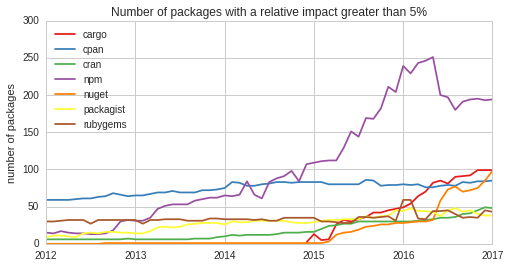

In [35]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

threshold = 5

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        p_threshold = graph.vcount() * threshold / 100
        df.loc[date, ecosystem] = len(graph.vs.select(**{'tr-in_ge': p_threshold}))
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='number of packages',
    title='Number of packages with a relative impact greater than {0}%'.format(threshold),
)

savefig(figure, 'graph_relative_impact_{}'.format(threshold))

In [36]:
pandas.concat([df.min(), df.max(), df.iloc[-1]], axis=1)

,0,1,2017-01-01 00:00:00
cargo,2.0,99.0,99
cpan,59.0,86.0,85
cran,6.0,49.0,48
npm,13.0,251.0,194
nuget,0.0,98.0,98
packagist,9.0,48.0,38
rubygems,27.0,59.0,43


In [37]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.973528,0.725461,0.884984,0.89231,0.617391,0.90709,0.304278
lin-log,0.746287,0.728448,0.941105,0.923746,0.698875,0.856321,0.337933
log-lin,0.600521,0.639334,0.388225,0.468639,0.214385,0.631877,0.141464
log-log,0.849212,0.664971,0.47652,0.663521,0.69442,0.745094,0.162835


In [38]:
for v in evolution_linlog_regressions(df.astype(float), return_raw=True).T.itertuples():
    print(v.Index)
    print(v[1].params[0])

cargo
0.13425079358
cpan
0.01307008772
cran
0.0226445480733
npm
0.130806071757
nuget
0.037623851865
packagist
0.0193249262751
rubygems
0.00619692558435


## Reusability & fragility metrics

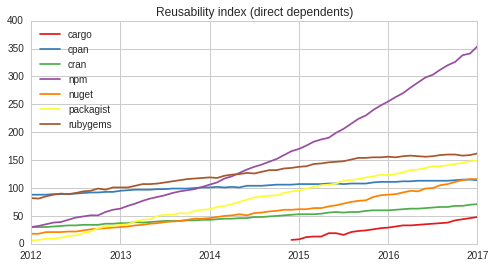

In [39]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = x_index(graph.vs['in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (direct dependents)',
)

savefig(figure, 'graph_reusability_index')

In [40]:
evolution_linlog_regressions(df.loc[pandas.to_datetime('2012-01-01'):].astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.984957,0.980056,0.994642,0.966154,0.972557,0.997326,0.982386
lin-log,0.902583,0.970682,0.993962,0.983861,0.985466,0.84757,0.965282
log-lin,0.634115,0.679675,0.593724,0.509015,0.535562,0.634427,0.660917
log-log,0.801125,0.698741,0.664778,0.715634,0.698701,0.844272,0.715221


In [41]:
for v in evolution_linlog_regressions(df.loc[pandas.to_datetime('2012-01-01'):].astype(float), return_raw=True).T.itertuples():
    print(v.Index)
    print(v[1].params[0])

cargo
0.0504197550772
cpan
0.0150170854494
cran
0.0220839418686
npm
0.175077185678
nuget
0.0526276799028
packagist
0.0818931455358
rubygems
0.0465078898809
